# Open Data From JSON

In [2]:
import pandas as pd
import numpy as np
import glob

In [3]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [4]:
amount_of_articles = len(df["maintext"])
print("Amount of articles: " + str(amount_of_articles))

Amount of articles: 23881


# Preprocessing 

In [5]:
import re

In [6]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [7]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [8]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

print("Tokenizing all articles. This may take a while.")
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continuing with lemmatization & noun extraction.")
i = 0
for element in df["tokenized_words"]:
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article
	i = i+1
	print("Lemmatizing & filtering nouns: " + str(i) + " / " + str(amount_of_articles), flush=True)

df["maintext_nouns"] = nouns

ouns: 23437 / 23881
Lemmatizing & filtering nouns: 23438 / 23881
Lemmatizing & filtering nouns: 23439 / 23881
Lemmatizing & filtering nouns: 23440 / 23881
Lemmatizing & filtering nouns: 23441 / 23881
Lemmatizing & filtering nouns: 23442 / 23881
Lemmatizing & filtering nouns: 23443 / 23881
Lemmatizing & filtering nouns: 23444 / 23881
Lemmatizing & filtering nouns: 23445 / 23881
Lemmatizing & filtering nouns: 23446 / 23881
Lemmatizing & filtering nouns: 23447 / 23881
Lemmatizing & filtering nouns: 23448 / 23881
Lemmatizing & filtering nouns: 23449 / 23881
Lemmatizing & filtering nouns: 23450 / 23881
Lemmatizing & filtering nouns: 23451 / 23881
Lemmatizing & filtering nouns: 23452 / 23881
Lemmatizing & filtering nouns: 23453 / 23881
Lemmatizing & filtering nouns: 23454 / 23881
Lemmatizing & filtering nouns: 23455 / 23881
Lemmatizing & filtering nouns: 23456 / 23881
Lemmatizing & filtering nouns: 23457 / 23881
Lemmatizing & filtering nouns: 23458 / 23881
Lemmatizing & filtering nouns: 2345

In [10]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

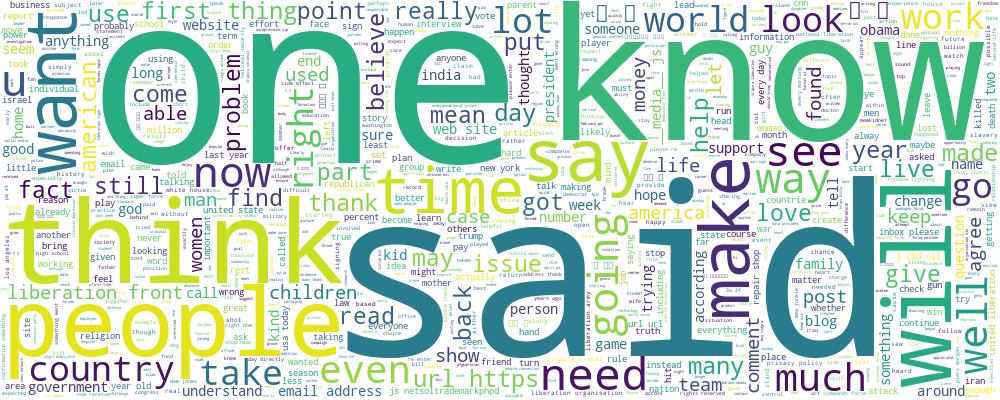

In [12]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

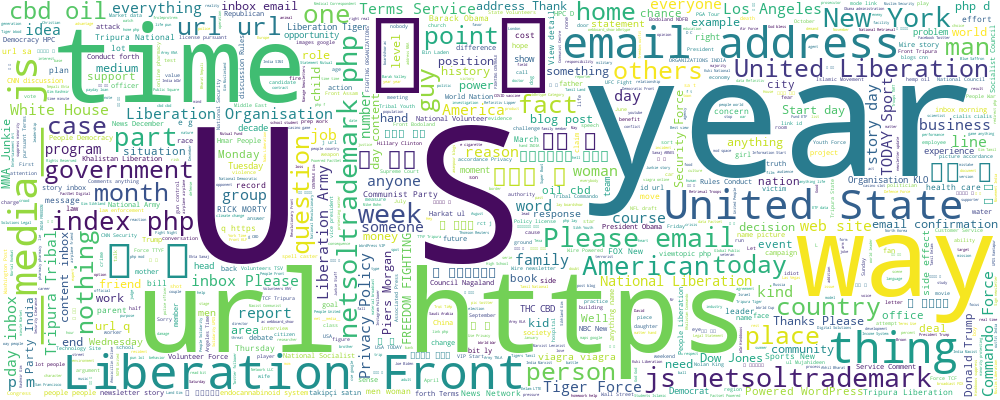

In [13]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [37]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
df["maintext_ready"]  = maintext_ready

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'maintext_nouns'

In [19]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa..."


# Wordcloud of the ready-to-cluster articles

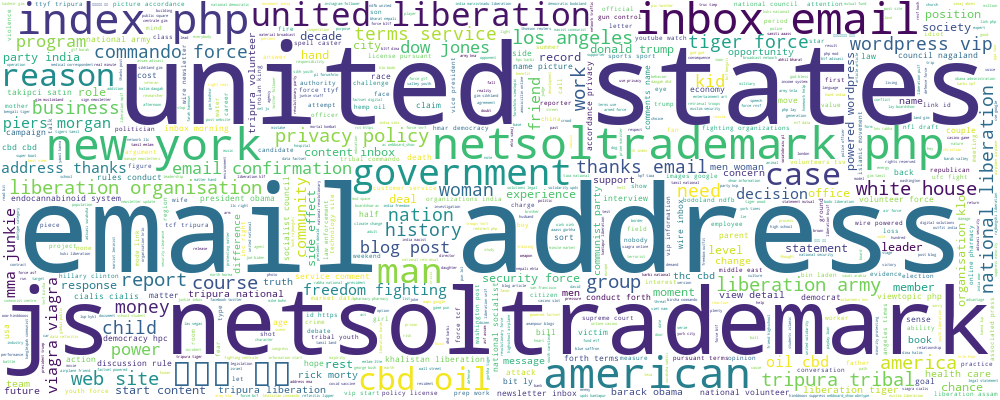

In [20]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [21]:
import gensim.corpora as corpora

In [22]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [23]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(1, 1), (25, 1), (26, 1), (27, 1), (28, 7), (..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(4, 1), (25, 5), (44, 1), (58, 1), (86, 1), (..."


# Build a LDA model (need to find fitting values here)

In [24]:
from pprint import pprint   #pretty printing

In [25]:
amount_of_topics = 20  #adjust to find good results

In [26]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

# Displaying the LDA model

In [27]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.007*"ufc" + 0.004*"www" + 0.003*"php" + 0.003*"email" + 0.003*"mma" + '
  '0.003*"site" + 0.003*"bellator" + 0.003*"blog" + 0.002*"fight" + '
  '0.002*"https"'),
 (1,
  '0.004*"trump" + 0.004*"national" + 0.004*"woman" + 0.004*"india" + '
  '0.004*"force" + 0.004*"tripura" + 0.004*"school" + 0.003*"president" + '
  '0.003*"game" + 0.003*"money"'),
 (2,
  '0.005*"force" + 0.004*"tripura" + 0.004*"php" + 0.004*"liberation" + '
  '0.003*"national" + 0.003*"site" + 0.003*"game" + 0.003*"president" + '
  '0.003*"www" + 0.003*"india"'),
 (3,
  '0.006*"team" + 0.003*"president" + 0.003*"email" + 0.003*"game" + '
  '0.003*"california" + 0.003*"season" + 0.003*"trump" + 0.002*"woman" + '
  '0.002*"ufc" + 0.002*"men"'),
 (4,
  '0.004*"email" + 0.003*"game" + 0.003*"ufc" + 0.003*"site" + 0.003*"inbox" + '
  '0.003*"blog" + 0.003*"video" + 0.003*"obama" + 0.002*"team" + '
  '0.002*"article"'),
 (5,
  '0.003*"child" + 0.003*"piers" + 0.003*"president" + 0.003*"force" + '
  '0.003*"woman" 

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [28]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [29]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.034942 -0.030684       1        1  13.804105
3      0.027556  0.014673       2        1   9.376437
11     0.009728 -0.006637       3        1   9.114593
9      0.008995 -0.001864       4        1   8.571277
7      0.015542 -0.017608       5        1   7.900166
13    -0.041610  0.025533       6        1   6.360489
5      0.004211 -0.012690       7        1   6.264780
8      0.010506 -0.000237       8        1   5.111284
6     -0.002050 -0.001545       9        1   4.379375
19     0.003548 -0.016763      10        1   3.898968
12    -0.001086 -0.009439      11        1   3.382496
17     0.001537  0.001648      12        1   3.134549
2     -0.014858 -0.003363      13        1   3.103666
4      0.011259  0.012726      14        1   3.097553
15     0.022042  0.002950      15        1   2.747776
0      0.009651  0.019678      16        1   2.621056
14    -0.004636 -0.001545      17        1   2.574425
1     -0.004462  0.008035      18        1   2.364667
10    -0.004213 -0.007416      19        1   1.725234
16    -0.016718  0.024549      20        1   0.467105, topic_info=              Term          Freq         Total Category  logprob  loglift
1300         force  37602.000000  37602.000000  Default  30.0000  30.0000
843     liberation  29104.000000  29104.000000  Default  29.0000  29.0000
8546           ufc  11509.000000  11509.000000  Default  28.0000  28.0000
35551      tripura  24842.000000  24842.000000  Default  27.0000  27.0000
893       national  26832.000000  26832.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
290    information    107.174693  24014.890843  Topic20  -6.2260  -0.0456
2077           php    107.628644  28336.561677  Topic20  -6.2218  -0.2069
312            man    103.531501  23273.505626  Topic20  -6.2606  -0.0488
340      president    103.781495  28141.506902  Topic20  -6.2582  -0.2363
646           blog    100.178256  31697.771670  Topic20  -6.2935  -0.3907

[1831 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
55909      1  0.127149  aamir
55909      2  0.063575  aamir
55909      4  0.031787  aamir
55909      7  0.063575  aamir
55909      8  0.031787  aamir
...      ...       ...    ...
44472     16  0.017627     ไม
44472     17  0.027352     ไม
44472     18  0.009725     ไม
44472     19  0.027960     ไม
44472     20  0.002431     ไม

[10209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 4, 12, 10, 8, 14, 6, 9, 7, 20, 13, 18, 3, 5, 16, 1, 15, 2, 11, 17])

# Store Cluster IDs to dataframe

In [30]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(3, '0.006*"team" + 0.003*"president" + 0.003*"email" + 0.003*"game" + 0.003*"california"')
(15, '0.004*"viagra" + 0.003*"site" + 0.003*"blog" + 0.003*"service" + 0.003*"www"')
(12, '0.003*"president" + 0.003*"site" + 0.003*"force" + 0.003*"service" + 0.003*"trump"')
(2, '0.005*"force" + 0.004*"tripura" + 0.004*"php" + 0.004*"liberation" + 0.003*"national"')
(5, '0.003*"child" + 0.003*"piers" + 0.003*"president" + 0.003*"force" + 0.003*"woman"')
(10, '0.006*"บอล" + 0.004*"woman" + 0.004*"force" + 0.004*"liberation" + 0.003*"school"')
(1, '0.004*"trump" + 0.004*"national" + 0.004*"woman" + 0.004*"india" + 0.004*"force"')
(16, '0.008*"force" + 0.007*"liberation" + 0.005*"ufc" + 0.005*"national" + 0.004*"tripura"')
(14, '0.005*"force" + 0.004*"www" + 0.004*"game" + 0.004*"site" + 0.004*"php"')
(6, '0.004*"blog" + 0.004*"obama" + 0.004*"site" + 0.003*"www" + 0.003*"india"')
C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_asyn

In [31]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
        if j == 0:  #dominant topic (only first one)
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topic_list.append(int(topic_num))
            topic_percentage_list.append(round(prop_topic,5))
            topic_keywords_list.append(topic_keywords)
        else: 
            break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1...",6,0.97551,"blog, obama, site, www, india, post, right, mo..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(1, 1), (25, 1), (26, 1), (27, 1), (28, 7), (...",5,0.46776,"child, piers, president, force, woman, php, บอ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(4, 1), (25, 5), (44, 1), (58, 1), (86, 1), (...",4,0.98073,"email, game, ufc, site, inbox, blog, video, ob..."


In [33]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
import datetime as dt

df['date_publish'] = pd.to_datetime(df['date_publish'])
df['date_modify'] = pd.to_datetime(df['date_modify'])
df['date_modify'] = df['date_modify'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['date_download'] = pd.to_datetime(df['date_download'])
df['date_download'] = df['date_download'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df['date_publish'] = df['date_publish'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords,month_year
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1...",6,0.97551,"blog, obama, site, www, india, post, right, mo...",2021-06
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(1, 1), (25, 1), (26, 1), (27, 1), (28, 7), (...",5,0.46776,"child, piers, president, force, woman, php, บอ...",2021-06
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(4, 1), (25, 5), (44, 1), (58, 1), (86, 1), (...",4,0.98073,"email, game, ufc, site, inbox, blog, video, ob...",2021-06


In [35]:
df = df.drop(columns=["maintext_prepro", "tokenized_words", "maintext_nouns", "maintext_ready", "corpus", "id"])
df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,month_year
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,6,0.97551,"blog, obama, site, www, india, post, right, mo...",2021-06
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,5,0.46776,"child, piers, president, force, woman, php, บอ...",2021-06
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,4,0.98073,"email, game, ufc, site, inbox, blog, video, ob...",2021-06
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,8,0.50833,"trump, woman, site, president, house, post, ga...",2021-06
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,5,0.57199,"child, piers, president, force, woman, php, บอ...",2021-06


In [36]:
import json

for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    os.makedirs(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}')
    for date, _ in data.groupby(data.month_year):
             json_data = data.to_json(orient='records', force_ascii=False, date_format='iso', date_unit='s')
             parsed = json.loads(json_data)
             with open(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}/{date}.json', 'w', encoding='utf-8') as f:
                 f.write(json.dumps({"data": parsed}, indent=4, ensure_ascii=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
